In which we combine what we know about `numpyro` with a basic optimization problem applied to a pricing scenario.

## Scenario:

You're at a farmer's market selling premium local honey. There is one other competitor that sells local honey too, but it's a little lower quality, so they typically have a lower price. 

As the business owner, what price should you set your honey at in order to maximize your revenue?

In [3]:
import jax.numpy as jnp
from jax import random
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


Imagine we have several weeks of price and sales history.

Because this is a simulation, we can specify the ground truth of the world.

Demand for our honey at any given week is a function of price - that is, at a given price, demand will be a random realization of a Normal distribution in which the mean $\mu$ is dependent on the price. We represent this function as:

$$
\begin{aligned}
y_i &\sim \mathcal{N}(\mu_i, \sigma)\\
\mu_i &= f(x_i, z_i)
\end{aligned}
$$

Where each $i$ is a potential price and $x_i$ is our price and $z_i$ is our competitor's price. For the sake of convenience we'll make $f(x_i, z_i)$ a simple linear regression model:

$$
\mu_i = \alpha + \beta_x x_i + \beta_z z_i
$$

In [19]:
# Generate data with JAX
n = 100

rng_key1, rng_key2 = random.split(random.PRNGKey(0))
# prices as arrays
x = dist.Uniform(low=7.99, high=12.99).sample(rng_key1, sample_shape=(n,))
z = dist.Uniform(low=4.99, high=6.99).sample(rng_key2, (n,))
# True model coefficients
true_alpha = 100
true_sigma = 1
true_beta = jnp.array([-5, 8])

# Generate fake demand observations in this simulated world where
# the model is true
# X = jnp.concatenate([x,z], axis=1)
# true_mu = X @ true_betas + true_alpha
# true_mu = true_mu.reshape(-1, 1)
true_mu = true_alpha + true_beta[0] * x + true_beta[1] * z
noise = dist.Normal(0, true_sigma).sample(random.PRNGKey(42), (n,))
demand_seen = true_mu + noise

''

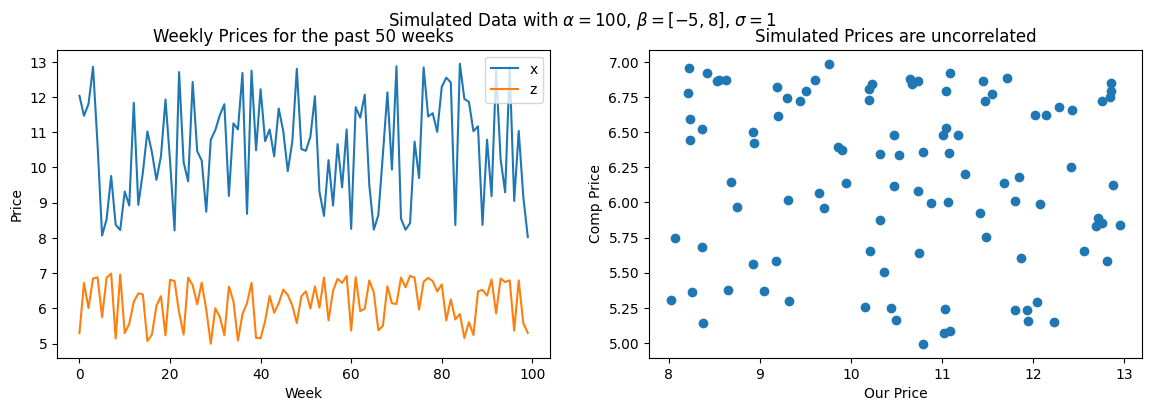

In [20]:
# Price comparison - in this simple world the prices are independent
fig, ax = plt.subplots(1,2, figsize=(14,4))

ax[0].plot(x, label='x')
ax[0].plot(z, label='z')
ax[0].legend()
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Price')
ax[0].set_title("Weekly Prices for the past 50 weeks");
ax[1].scatter(x,z)
ax[1].set_xlabel('Our Price')
ax[1].set_ylabel('Comp Price')
ax[1].set_title('Simulated Prices are uncorrelated')
fig.suptitle(rf"Simulated Data with $\alpha={true_alpha}$, $\beta = [{true_beta[0]}, {true_beta[1]}]$, $\sigma={true_sigma}$")
;

Text(0.5, 0, 'Comp Price')

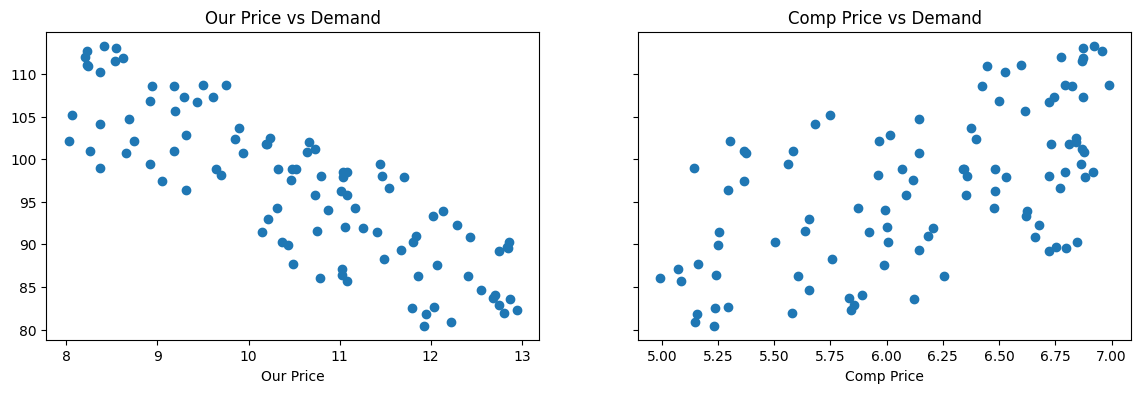

In [22]:
# But each price goes on to influence Demand
fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,4))
ax[0].scatter(x,demand_seen)
ax[0].set_title("Our Price vs Demand")
ax[0].set_xlabel('Our Price')
ax[1].scatter(z,demand_seen)
ax[1].set_title("Comp Price vs Demand")
ax[1].set_xlabel('Comp Price')

It should be noted here that in this simulated world, prices are independent and are the two sole causes of demand. Seasonality and weather don't come into play here, and unlike the real world the prices are independent whereas this does not hold true in the real world where prices must be competitive. You can simply look at gas stations in your area and see this pricing influence at play.

## Solving this with OLS

We can quite easily solve this equation with OLS:

In [23]:
import statsmodels.api as sm

exog = sm.add_constant(np.stack([x,z], axis=1))
endog = np.array(demand_seen)
model = sm.OLS(endog, exog, hasconst=True)
results = model.fit()
results.params

array([99.66877841, -4.92253608,  7.92284401])

In [24]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.986   
Dependent Variable: y                AIC:                292.2127
Date:               2024-02-23 16:56 BIC:                300.0282
No. Observations:   100              Log-Likelihood:     -143.11 
Df Model:           2                F-statistic:        3606.   
Df Residuals:       97               Prob (F-statistic): 9.12e-92
R-squared:          0.987            Scale:              1.0562  
-------------------------------------------------------------------
         Coef.    Std.Err.      t       P>|t|     [0.025    0.975] 
-------------------------------------------------------------------
const   99.6688     1.3527    73.6792   0.0000   96.9840   102.3536
x1      -4.9225     0.0718   -68.5968   0.0000   -5.0650    -4.7801
x2       7.9228     0.1738    45.5917   0.0000    7.5779     8.2677
-----------------------------------------------------------------
Omnibus:              2.262        Durbin-Watson:           1.799
Prob(Omnibus):        0.323        Jarque-Bera (JB):        1.738
Skew:                 0.150        Prob(JB):                0.419
Kurtosis:             2.428        Condition No.:           163  
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

And we see that it did a fairly good job of estimating the unknown parameters, though the true parameters aren't contained in the 95% confidence intervals for the intercept and the first coefficient, which is a little concerning. 

However, we aren't quite done yet. Our goal in this decision is to recommend a specific *action* - the price we should set that would optimize our revenue (demand * price). We need to recommend a price $x_i$ that would maximize $y_i$ across values of $z$. 

## Using a Bayesian model to Infer the hidden parameters

Now, to help our decisionmaker with this pricing question, we can use a bayesian approach in which we want to estimate the hidden parameters.

In [25]:
def demand_model(y, x, z):

    # priors
    alpha = numpyro.sample('alpha', dist.Normal(loc=50., scale=10.))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    betas = numpyro.sample('beta', dist.Normal(jnp.zeros(2), jnp.ones(2)))
    
    # likelihood
    mu = alpha + betas[0] * x + betas[1] * z
    return numpyro.sample('demand', dist.Normal(mu, sigma), obs=y)

# inference
kernel = NUTS(demand_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)
mcmc.run(random.PRNGKey(42), y=demand_seen, x=x, z=z)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1624.58it/s, 31 steps of size 5.44e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha    100.00      1.35     99.99     97.84    102.23    289.85      1.03
   beta[0]     -4.87      0.07     -4.87     -4.98     -4.74    308.99      1.01
   beta[1]      7.77      0.18      7.78      7.49      8.05    304.94      1.01
     sigma      1.04      0.07      1.04      0.92      1.16    605.31      1.00

Number of divergences: 0


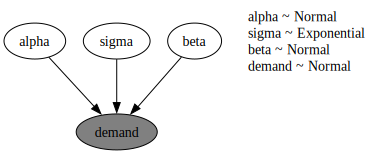

In [26]:
numpyro.render_model(demand_model, (demand_seen, x, z), render_distributions=True)

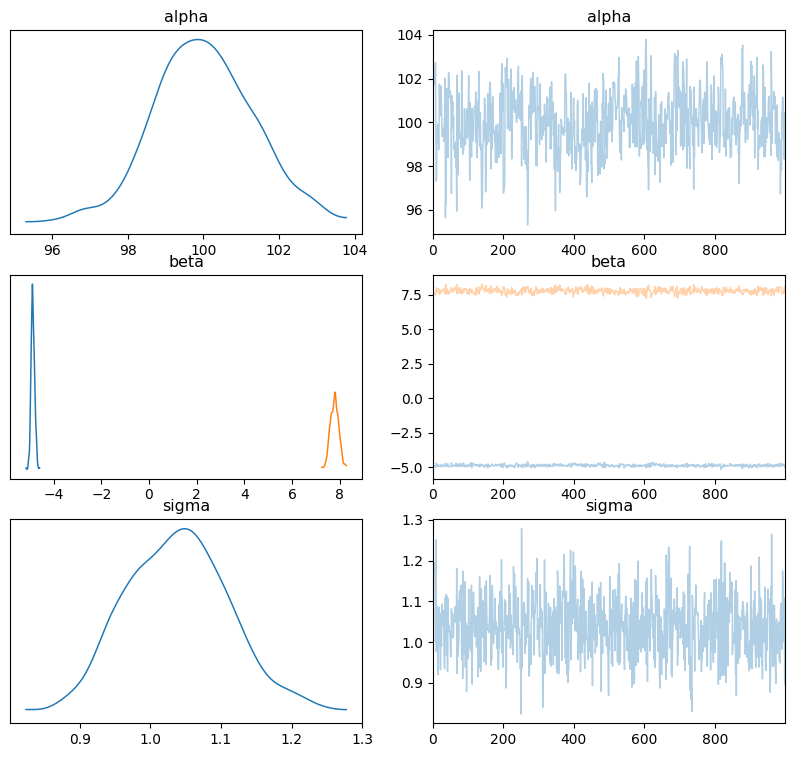

In [27]:
import arviz as az

az.plot_trace(mcmc, figsize=(10,9));

Examine the posterior predictive distribution of `demand` given our past values of `X`. Note that we leave `y=None` so we can get our predictions.

In [28]:
posterior_samples = mcmc.get_samples()

# call Predictive()
rng_key2, rng_key3 = random.split(rng_key2)
posterior_predictive = Predictive(demand_model, posterior_samples=posterior_samples)
posterior_predictions = posterior_predictive(rng_key3, y=None, x=x, z=z)['demand']  # note that y=None here
posterior_predictions.shape #(1000, 50)

(1000, 100)

Note the shape of the predictions is (1000, 50) which is 1000 samples for each of the 50 combinations of $(x,z)$ we had in our data `X`. 

In other words, we have 1000 samples for every pair $(x,z)$ aka (our price, comp price) we had in `X`. 

To make it more concrete, let's look at two $(x,z)$ pairs and the posterior distribution of demand for each pair:

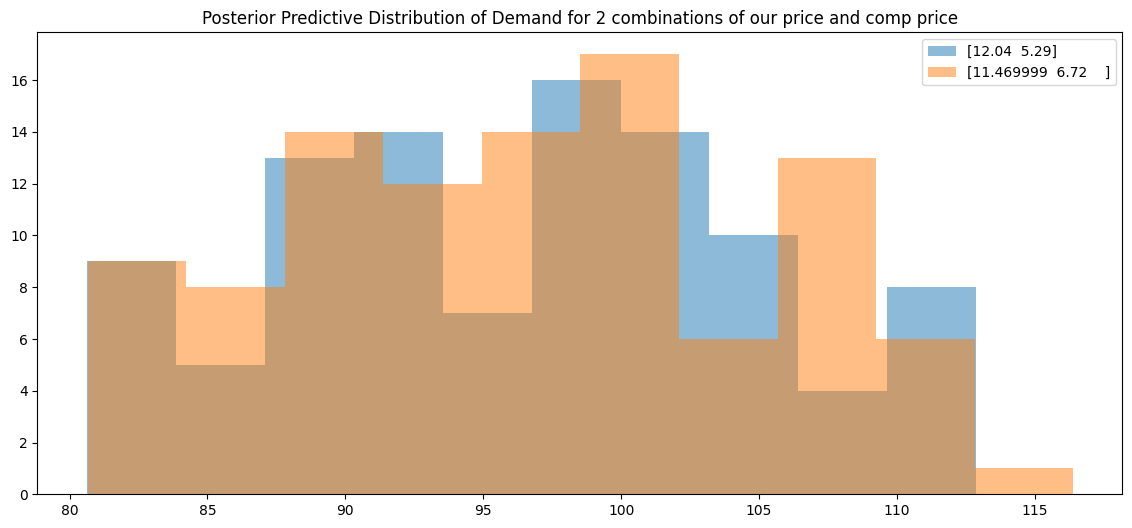

In [29]:
fig, ax = plt.subplots(figsize=(14,6))
for i in range(2):
    ax.hist(posterior_predictions[i].flatten(), alpha=0.5, label=f"{jnp.round(jnp.array([x[i], z[i]]),2)}")
ax.set_title("Posterior Predictive Distribution of Demand for 2 combinations of our price and comp price")
ax.legend();

We see that our model returned not just a single predicted value of distribution, but we get samples from the *posterior predictive distribution* for each $(x,z)$ pair!

We can also plot the entire posterior predictive distribution for all the values of $(x,z)$:

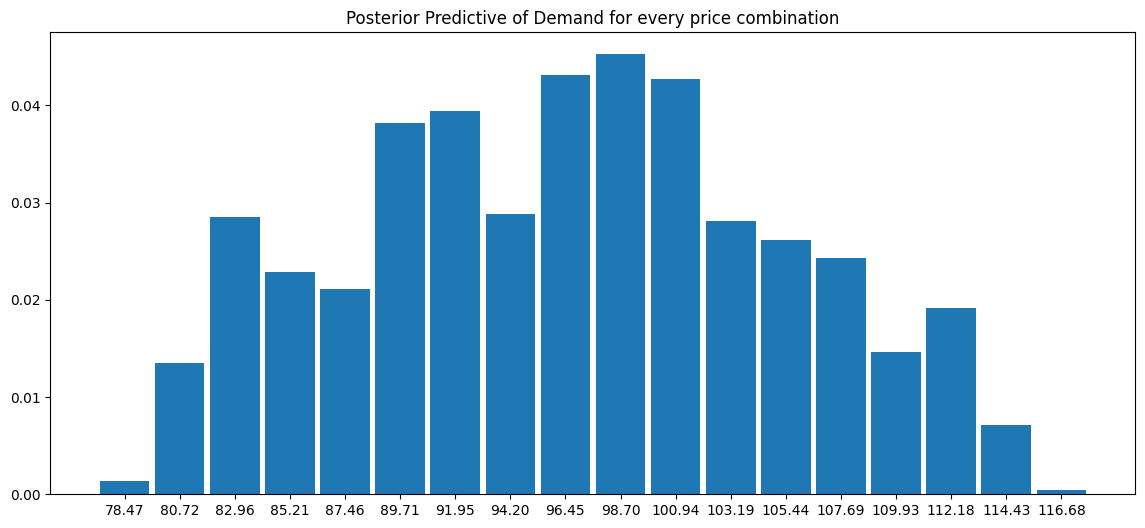

In [30]:
fig, ax = plt.subplots(figsize=(14,6))
az.plot_dist(posterior_predictions.flatten(), kind='hist', ax=ax)
ax.set_title("Posterior Predictive of Demand for every price combination");

But what we really want to do is to see if we can find a price strategy that will optimize our revenue. One way to do this is to have a recommended 'price gap' - a strategy in which you set your price at some threshold above a competitor's price. 

We can do this by examining our posterior data 

Text(0.5, 1.0, 'Distribution of Price Gaps (in $)')

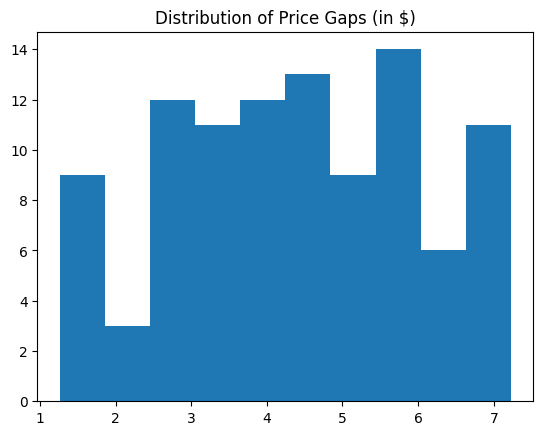

In [31]:
gaps = (x-z).flatten()

plt.hist(gaps)
plt.title('Distribution of Price Gaps (in $)')

We see that most of the time we either priced between \$1-4, \$4-6, and more than \$6 above competition. We can categorize our data and look at the posterior distributions for each price gap range:

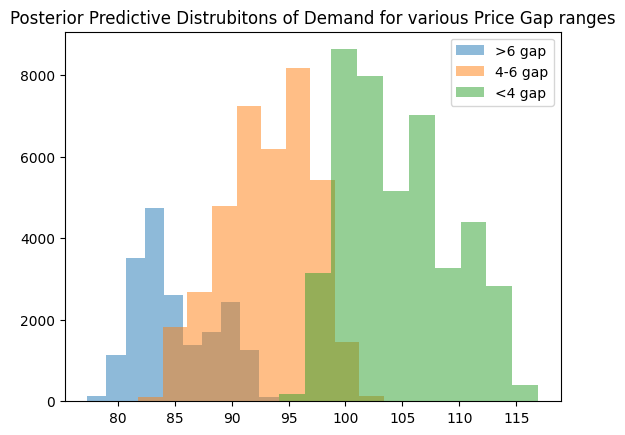

In [32]:
idx = gaps >= 6
idx2 = ((gaps >= 4) & (gaps < 6))
idx3 = (gaps < 4)
plt.hist(posterior_predictions[:, idx].flatten(), label='>6 gap', alpha=0.5)
plt.hist(posterior_predictions[:, idx2].flatten(), label='4-6 gap', alpha=0.5)
plt.hist(posterior_predictions[:, idx3].flatten(), label='<4 gap', alpha=0.5)
plt.legend()
plt.title("Posterior Predictive Distrubitons of Demand for various Price Gap ranges");

And we see that as our price gap increased over competition, our demand declined (according to this simple model). But if we want to optimize our revenue, (not just unit sales), we need to translate these demand predictions into revenue and examine the posterior distributions:

Text(0.5, 1.0, 'Posterior Predictive Distributions of Revenue for various Price Gap ranges')

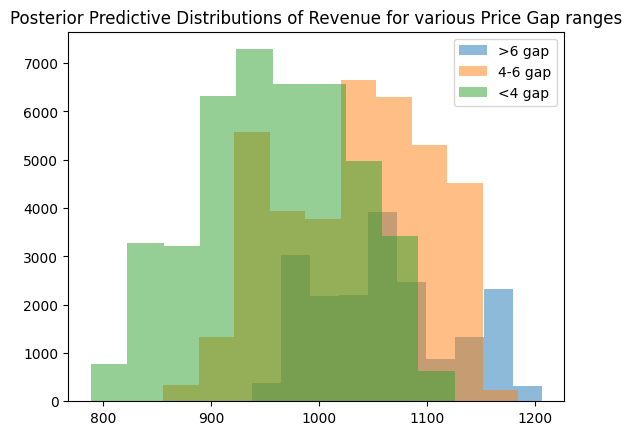

In [33]:
# Calculate revenue as demand * our price x
posterior_revenue = posterior_predictions * x

plt.hist(posterior_revenue[:, idx].flatten(), label='>6 gap', alpha=0.5)
plt.hist(posterior_revenue[:, idx2].flatten(), label='4-6 gap', alpha=0.5)
plt.hist(posterior_revenue[:, idx3].flatten(), label='<4 gap', alpha=0.5)
plt.legend()
plt.title("Posterior Predictive Distributions of Revenue for various Price Gap ranges")

Now the recommendation looks a little more interesting - according to this model, the \$4-6 price gap would give us better revenue (on average) and offers more upside!

In [34]:
# means:
print(posterior_revenue[:, idx].flatten().mean())
print(posterior_revenue[:, idx2].flatten().mean())
print(posterior_revenue[:, idx3].flatten().mean())

1060.9773
1032.8043
960.3756


## Enhancement 1: What if comp price is a random variable

Let's say we want to treat comp price $z$ as a random variable, because it may tell us something about the underlying comp pricing strategy or we have some prior information into how they might price.

Every random variable must have a prior distribution - which we add in as a new line in our demand model:

In [35]:
def demand_model2(y, x, z):

    # priors
    alpha = numpyro.sample('alpha', dist.Normal(loc=50., scale=10.))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    betas = numpyro.sample('beta', dist.Normal(jnp.zeros(2), jnp.ones(2)))
    
    # What if z is unknown and we want to test on the rare chance they price higher than before
    z_high = numpyro.sample('z_high', dist.Uniform(low=7., high=12.))
    sim_z = numpyro.sample('z', dist.TruncatedNormal(6, 1, low=4.99, high=z_high), obs=z)

    # likelihood
    mu = alpha + betas[0] * x + betas[1] * sim_z
    return numpyro.sample('demand', dist.Normal(mu, sigma), obs=y)

# inference
kernel = NUTS(demand_model2)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(random.PRNGKey(42), y=demand_seen, x=x, z=z)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:01<00:00, 1850.74it/s, 63 steps of size 5.95e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     99.92      1.32     99.96     97.93    102.26    854.77      1.00
   beta[0]     -4.87      0.07     -4.87     -4.99     -4.76   1266.05      1.00
   beta[1]      7.79      0.17      7.80      7.51      8.06    995.87      1.00
     sigma      1.04      0.08      1.04      0.93      1.17   1557.03      1.00
    z_high      7.03      0.03      7.02      7.00      7.07   1848.31      1.00

Number of divergences: 0


In [36]:
posterior_samples = mcmc.get_samples()

# call Predictive()
rng_key2, rng_key3 = random.split(rng_key2)
posterior_predictive = Predictive(demand_model2, posterior_samples)
posterior_predictions = posterior_predictive(rng_key3, y=None, x=x, z=None)

In this reality we can now get a posterior predictive distributions of $z$:

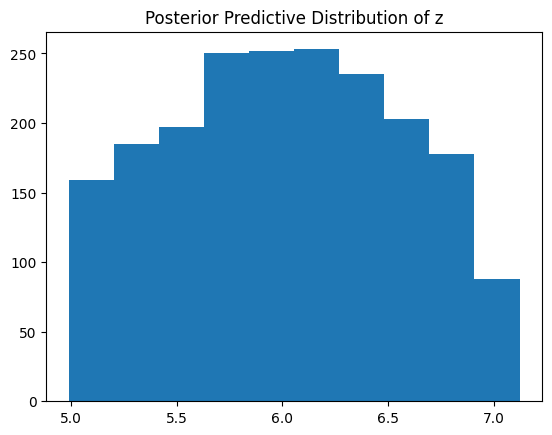

In [37]:
plt.hist(posterior_predictions['z'].flatten())
plt.title("Posterior Predictive Distribution of z");

We see that most of the weight is between 5-7 but it will still at least consider prices above 7. How does this change our price gap recommendation?

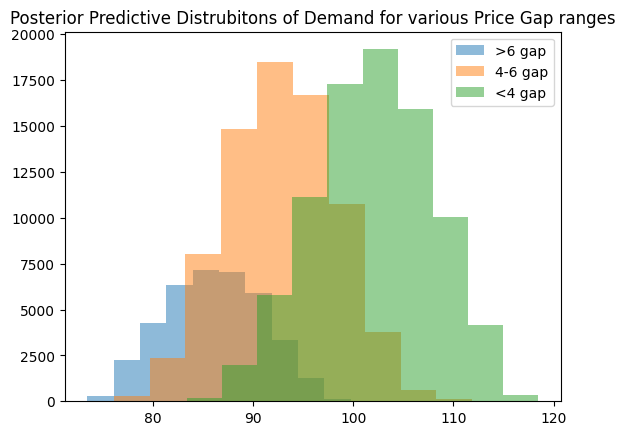

In [38]:
plt.hist(posterior_predictions['demand'][:, idx].flatten(), label='>6 gap', alpha=0.5)
plt.hist(posterior_predictions['demand'][:, idx2].flatten(), label='4-6 gap', alpha=0.5)
plt.hist(posterior_predictions['demand'][:, idx3].flatten(), label='<4 gap', alpha=0.5)
plt.legend()
plt.title("Posterior Predictive Distrubitons of Demand for various Price Gap ranges");

Text(0.5, 1.0, 'Posterior Predictive Distributions of Revenue for various Price Gap ranges')

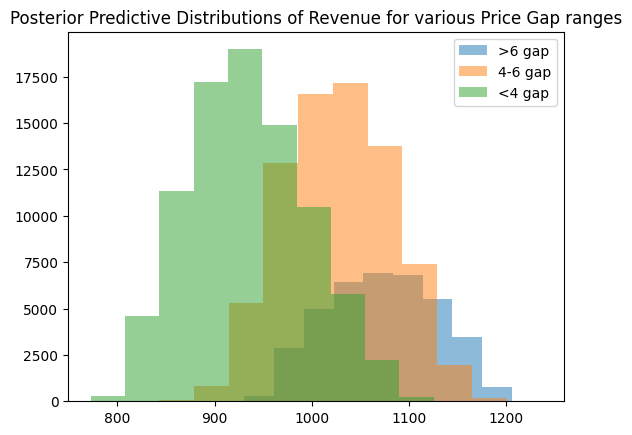

In [39]:
# Calculate revenue as demand * our price x
posterior_revenue = posterior_predictions['demand'] * x

plt.hist(posterior_revenue[:, idx].flatten(), label='>6 gap', alpha=0.5)
plt.hist(posterior_revenue[:, idx2].flatten(), label='4-6 gap', alpha=0.5)
plt.hist(posterior_revenue[:, idx3].flatten(), label='<4 gap', alpha=0.5)
plt.legend()
plt.title("Posterior Predictive Distributions of Revenue for various Price Gap ranges")

We see things have changed somewhat. Now, we don't see much of a difference between the >6 gap and the >4-6 gap anymore. Maybe the >\$6 gap edges out:

In [40]:
# means:
print(posterior_revenue[:, idx].flatten().mean())
print(posterior_revenue[:, idx2].flatten().mean())
print(posterior_revenue[:, idx3].flatten().mean())

1072.4144
1026.9081
934.88336
